In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from einops import rearrange
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

In [75]:
SIZE = "large"  # model size: choose from {'small', 'base', 'large'}
CTX = 200  # context length: any positive integer
PDT =  68
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST=100

# 1. Forecasting with Moirai

<img src="img/pred_def.png" alt="Drawing" style="width: 800px;"/>

Given a time series, Moirai (prediction model) use the context window as input and outputs a prediction window. So, the user need to set the **context_length** and **prediction_length** in advance. 

For time series data, the information contained within a single timestamp is not rich enough. Therefore, we refer to consecutive time points as 'patches', forming the basic units of Moirai input (similar to the concept of word token in Language Models). Moirai provides various ***patch_size*** [8, 16, 32, 64, 128].

Additionally, users need to select the **model size** ('small', 'base', 'large') of Moirai for prediction, along with the **batch_size**, which determines the number of samples that can be inferred in parallel. Since Moirai supports probablistic forecast, users should specify the **num_samples**, indicating the number of times it has to sample the forecasting distribution.

     datetime  count
0  2008-01-01    120
1  2008-01-02     89
2  2008-01-03    146
3  2008-01-04    166
4  2008-01-05     94
total length: 3653
time frequency: 1 days 00:00:00


<Axes: xlabel='datetime'>

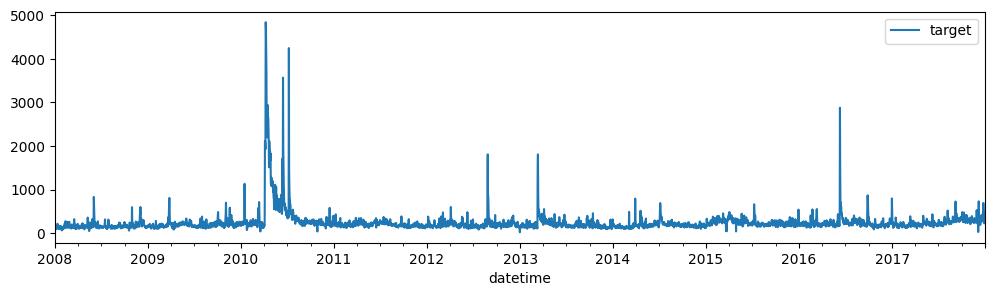

In [76]:
# Load dataframe and plot it
# first we load data/data_qtm_catalog.csv
df = pd.read_csv("../data/data_qtm_catalog.csv")
print(df.head())
# move datetime as index of the dataframe
df["datetime"] = pd.to_datetime(df["datetime"])
# rename count to target
df = df.rename(columns={"count": "target"})
df = df.set_index("datetime")
# df = df[df["item_id"] == "A"].drop(columns=["item_id"])
print(f"total length: {df.shape[0]}")
print(f"time frequency: {df.index.diff()[1]}")
df.plot(figsize=(12, 3))


In [77]:
#how many batches can we have given the CTX size and the length of the dataset
BSZ = (len(df)-PDT)//CTX
print(f"batch size: {BSZ}") 

batch size: 17


In [78]:
# prepare data for moirai
newdata = rearrange(df["target"].to_numpy()[:CTX*BSZ], "(b c) -> b c", b=BSZ, c=CTX)
print(df["target"].to_numpy().shape)
print(newdata.shape)

# now create an array of start dates
start_dates = df.index[:CTX*BSZ:CTX].to_period("D")

# prepare input for moirai
inp = {
    "target": newdata,
    "start": start_dates,
    "feat_static_cat": np.array([0]*BSZ)
}

(3653,)
(17, 200)


In [113]:
# create an array of label data by looping over in batch data and filing the label with the next CTX values
newlabeldata = np.zeros(shape=(BSZ, PDT))
newstart = np.zeros(BSZ, dtype=type(df.index[CTX].to_period(freq="D")))
for i in range(BSZ):
    newlabeldata[i,:] = df["target"].to_numpy()[i*CTX:i*CTX+PDT]
    if i < BSZ-1:
        newstart[i] = start_dates[i+1] #df.index[i*(CTX+1)].to_period("D")
    else:
        newstart[i] = df.index[CTX*BSZ+1].to_period("D")

# create a sample for the hourly data, using one week data as context window and predicting the next two days.
label = {
    "target": newlabeldata, 
    "start": newstart,
}

In [114]:
# print the input and label data, I want to see that the data is correctly prepared
print(inp)
print(label)

{'target': array([[120,  89, 146, ..., 319, 162, 153],
       [140, 121, 170, ..., 284, 125, 145],
       [109, 142, 115, ..., 136, 192, 167],
       ...,
       [188, 205, 162, ..., 220, 226, 209],
       [181, 218, 228, ..., 327, 190, 220],
       [263, 184, 197, ..., 148, 179, 196]]), 'start': PeriodIndex(['2008-01-01', '2008-07-19', '2009-02-04', '2009-08-23',
             '2010-03-11', '2010-09-27', '2011-04-15', '2011-11-01',
             '2012-05-19', '2012-12-05', '2013-06-23', '2014-01-09',
             '2014-07-28', '2015-02-13', '2015-09-01', '2016-03-19',
             '2016-10-05'],
            dtype='period[D]', name='datetime'), 'feat_static_cat': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
{'target': array([[120.,  89., 146., ..., 159., 200., 149.],
       [140., 121., 170., ..., 122., 177., 151.],
       [109., 142., 115., ..., 177.,  87.,  92.],
       ...,
       [188., 205., 162., ..., 203., 170., 166.],
       [181., 218., 228., ..., 157., 212., 205.

In [115]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=32,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

# Time series values for gluonts with shape (batch, time, variate)
past_target = rearrange(
    torch.as_tensor(inp["target"], dtype=torch.float32), "b c -> b c ()"
)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)
print(forecast.shape,CTX,PDT,BSZ)

In [117]:
print(
    "median prediction:\n",
    np.round(np.median(forecast[1], axis=1), decimals=4),
)
print("ground truth:\n", label["target"][1])

median prediction:
 [147.4909 158.2122 143.1447 149.993  163.672  150.789  163.4456 156.7928
 152.6966 155.691  149.7829 149.5772 155.4619 153.3286 164.0861 156.0251
 163.2296 163.61   150.3594 149.9608 145.5896 153.1804 159.0693 159.7136
 160.4512 156.9062 154.3594 157.7956 160.2758 161.6139 149.6462 163.0425
 148.9349 163.2888 158.0091 140.4831 158.9323 155.2211 147.9187 157.1016
 159.7736 165.8934 162.1128 152.9066 161.5079 170.6988 148.1404 157.8549
 153.7648 156.9958 161.2049 157.18   157.5525 170.2651 153.7922 161.6275
 150.7797 161.2105 173.746  159.2382 161.238  147.4662 155.5758 147.3198
 164.1387 174.2865 143.8295 153.4671 143.6078 159.5483 157.6483 151.093
 158.1755 152.1936 151.9459 157.9034 162.3866 163.2404 146.9271 153.7613
 162.7925 163.4269 163.4564 170.654  153.939  156.6216 149.747  152.2687
 162.1241 151.3421 154.0277 167.973  146.9084 166.0536 173.9168 147.4014
 158.0399 146.9603 160.3858 147.792 ]
ground truth:
 [140. 121. 170. 158.  99. 165. 111. 152. 137. 135. 3

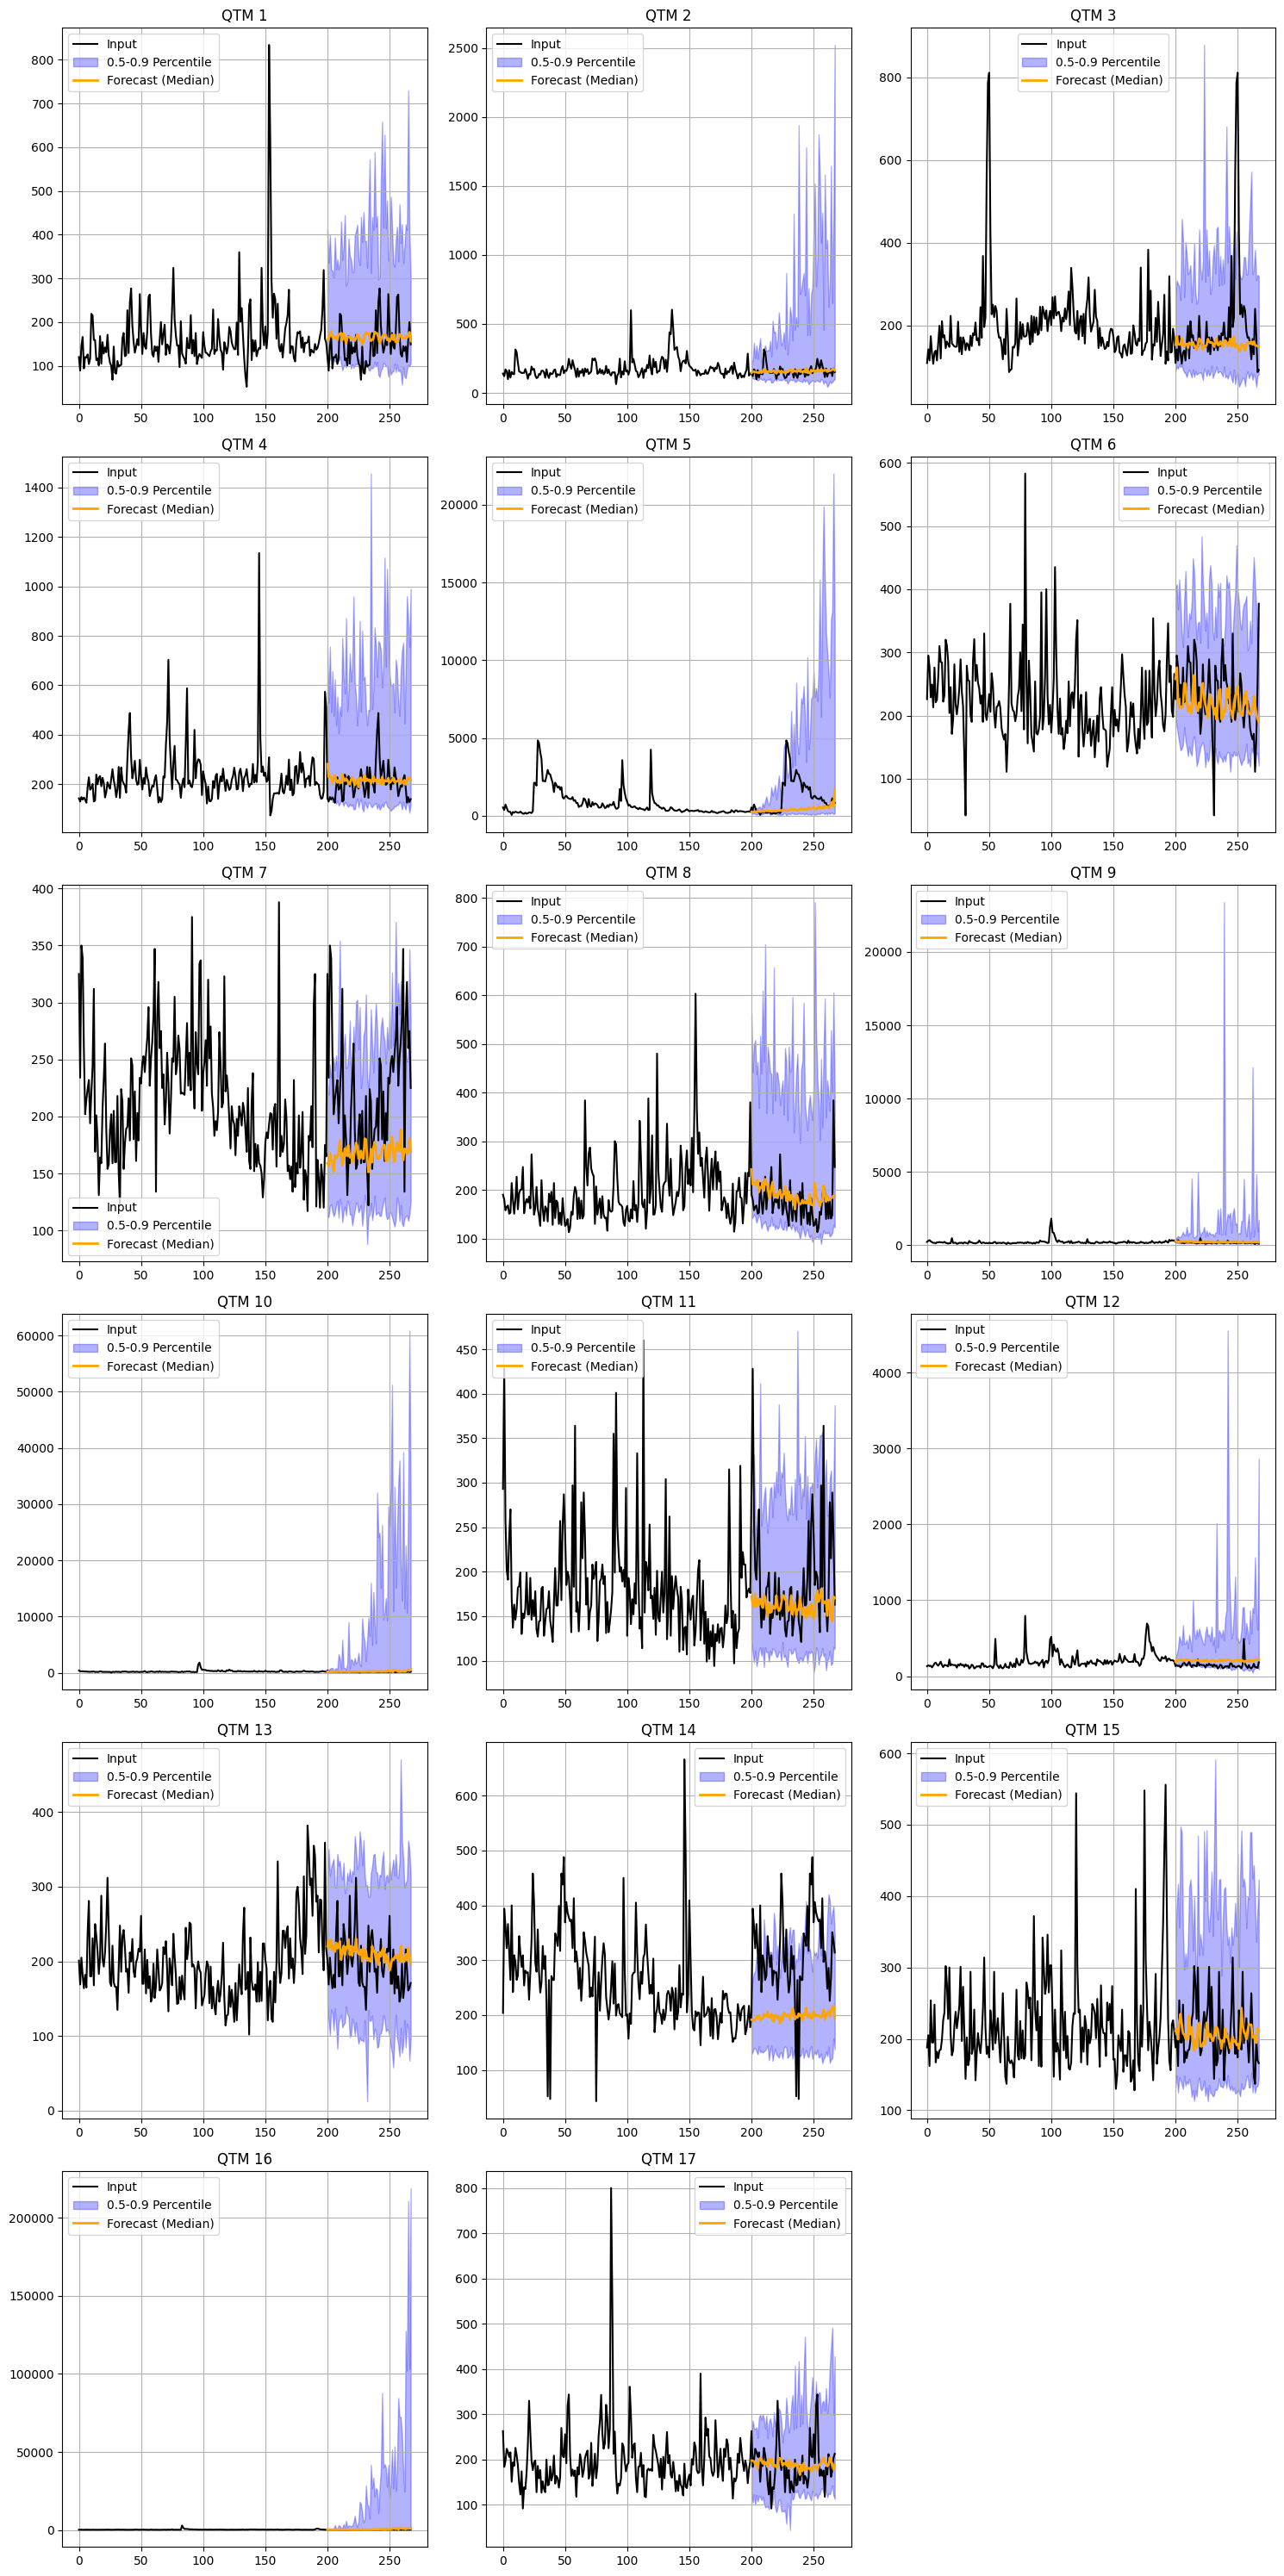

In [149]:

nrows = 6
ncols = 3
# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 30))
axes = axes.flatten()

for i in range(BSZ):
    ax = axes[i]

    # create a time array for the x-axis
    time_steps = np.arange(0, len(inp["target"][i])+len(label["target"][i]))
    
    # concatenate the input and label data
    crap=np.concatenate([inp["target"][i,:],label["target"][i]])
    #
    # Plot input data
    ax.plot(time_steps,crap, label='Input', color='black')
    
    
    # Plot 0.5 and 0.9 percentiles
    lower_percentile = np.percentile(forecast[i], 5, axis=0)
    upper_percentile = np.percentile(forecast[i], 95, axis=0)
    ax.fill_between(time_steps[CTX:CTX+PDT], lower_percentile, upper_percentile, color='blue', alpha=0.3, label='0.5-0.9 Percentile')


    # # Plot forecasted data
    median_forecast = np.median(forecast[i], axis=0)
    ax.plot(time_steps[CTX:CTX+PDT],median_forecast, label='Forecast (Median)', color='orange',linewidth=2)
    
    ax.grid(True)
    
    ax.set_title(f'QTM {i+1}')
    ax.legend()

# Hide any unused subplots
for j in range(BSZ, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("./plots/morai_qtm_forecast.png")
plt.savefig("./plots/morai_qtm_forecast.svg")
plt.show()


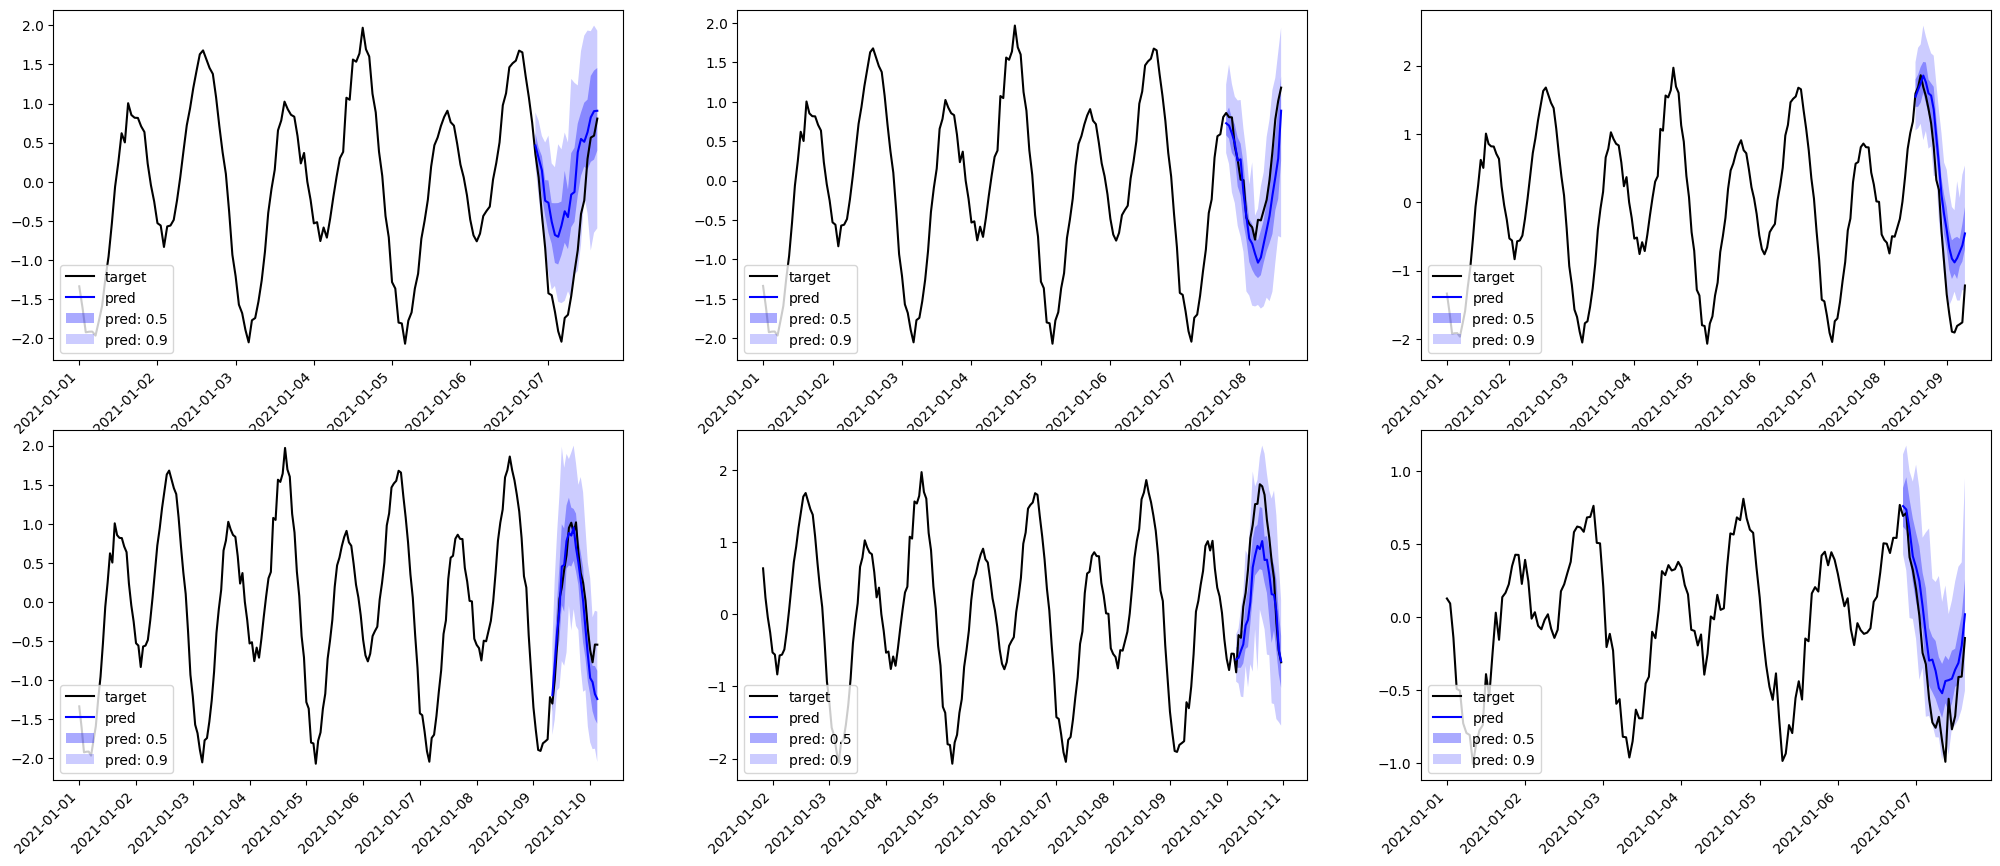

In [10]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

## 2.2 Loading from a _wide_ DataFrame

In [11]:
# Load dataframe
url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url_wide, index_col=0, parse_dates=True)

df.head()

,A,B,C,D,E,F,G,H,I,J
2021-01-01 00:00:00,-1.3378,0.1268,-0.3645,-1.0864,-2.3803,-0.2447,2.2647,-0.7917,0.7071,1.3763
2021-01-01 01:00:00,-1.6111,0.0926,-0.1364,-1.1613,-2.1421,-0.3477,2.4262,-0.9609,0.6413,1.2750
2021-01-01 02:00:00,-1.9259,-0.1420,0.1063,-1.0405,-2.1426,-0.3271,2.4434,-0.9034,0.4323,0.6767
2021-01-01 03:00:00,-1.9184,-0.4930,0.6269,-0.8531,-1.7060,-0.3088,2.4307,-0.9602,0.3193,0.5150
2021-01-01 04:00:00,-1.9168,-0.5057,0.9419,-0.7666,-1.4287,-0.4284,2.3258,-1.2504,0.3660,0.1708


In [12]:
# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [13]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

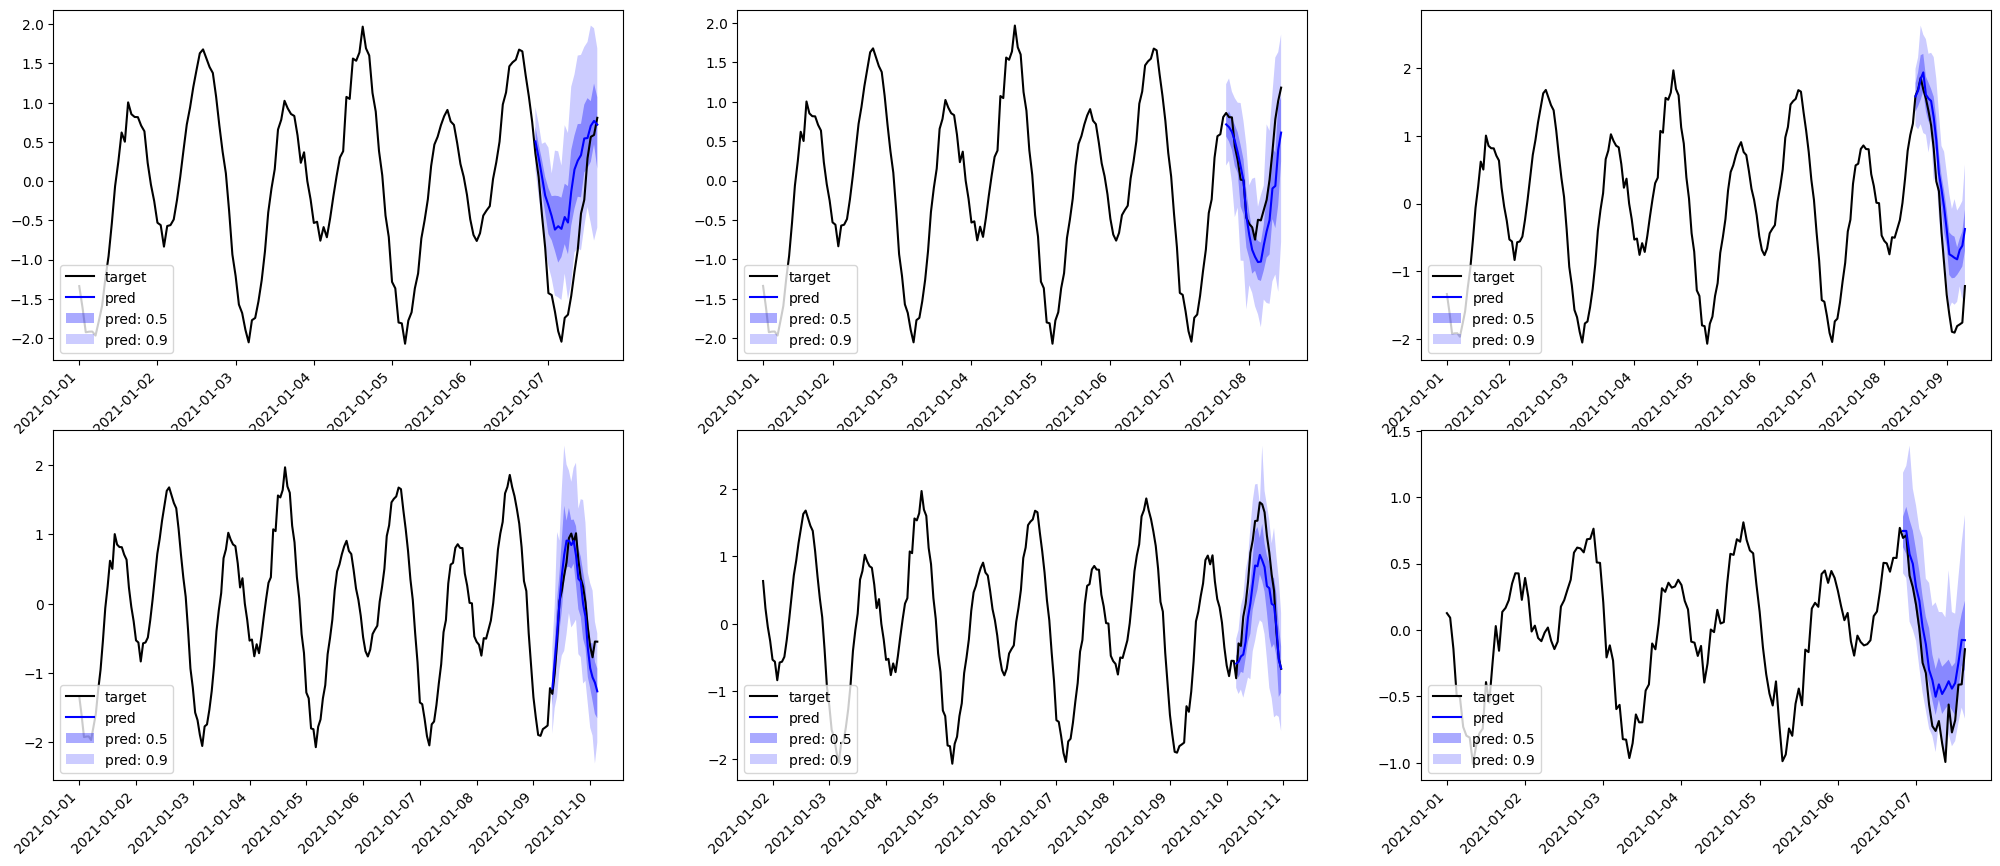

In [14]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

# 2.3 Multivariate Forecasting

In [15]:
# Load dataframe
url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df = pd.read_csv(url_wide, index_col=0, parse_dates=True)

In [16]:
# Convert into GluonTS dataset
ds = PandasDataset(dict(df))

# Group time series into multivariate dataset
grouper = MultivariateGrouper(len(ds))
multivar_ds = grouper(ds)

# Split into train/test set
train, test_template = split(
    multivar_ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [17]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=len(ds),
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [18]:
# Make predictions
inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

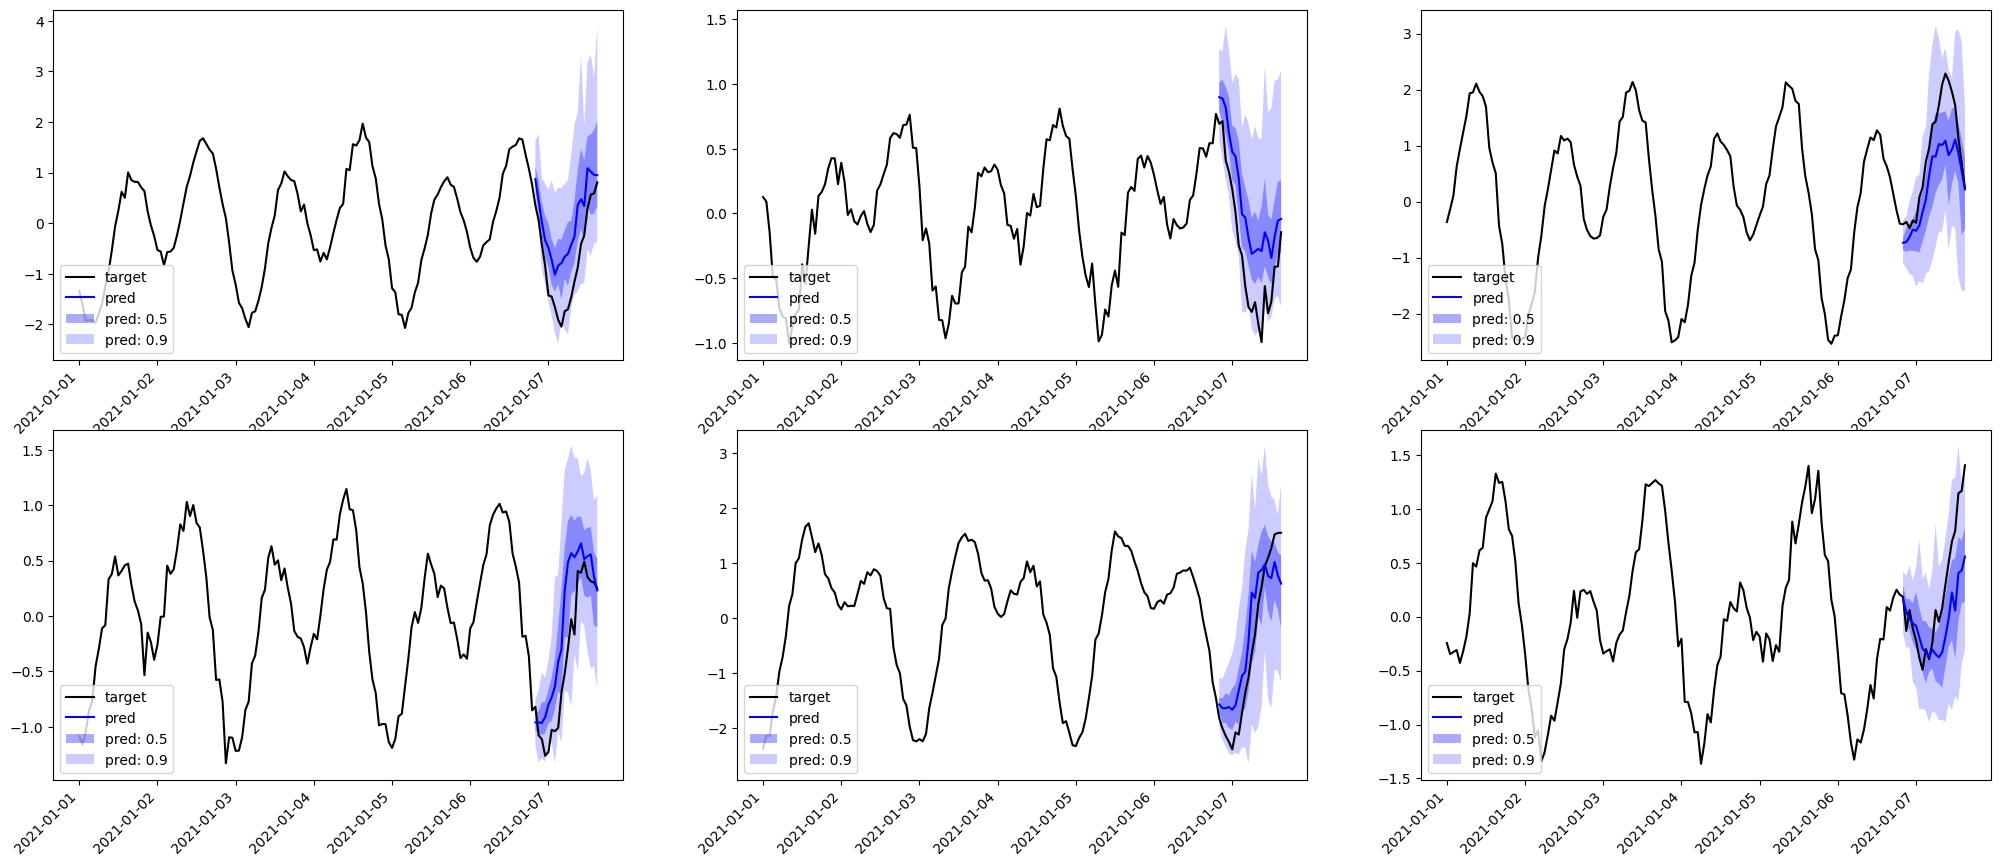

In [19]:
# Visualize different dimensions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
for i, ax in enumerate(axes.flatten()):
    plot_single(
        inp,
        label,
        forecast,
        context_length=200,
        intervals=(0.5, 0.9),
        dim=i,
        ax=ax,
        name="pred",
        show_label=True,
    )

## 2.4 Include dynamic features

<img src="img/extra_feature.png" alt="Drawing" style="width: 800px;"/>

Moirai supports adding additional covariates. Specifically, it could include past dynamic real features, and dynamic real feature that include features in the prediction window.

In [20]:
# Load dataframe
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
T = df.shape[0]
df["dynamic_real_1"] = np.random.normal(size=T)
df["past_dynamic_real_2"] = np.random.normal(size=T)

In [21]:
ds = PandasDataset.from_long_dataframe(
    df,
    item_id="item_id",
    past_feat_dynamic_real=["past_dynamic_real_2"],
    feat_dynamic_real=["dynamic_real_1"],
)

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

In [22]:
# Prepare model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

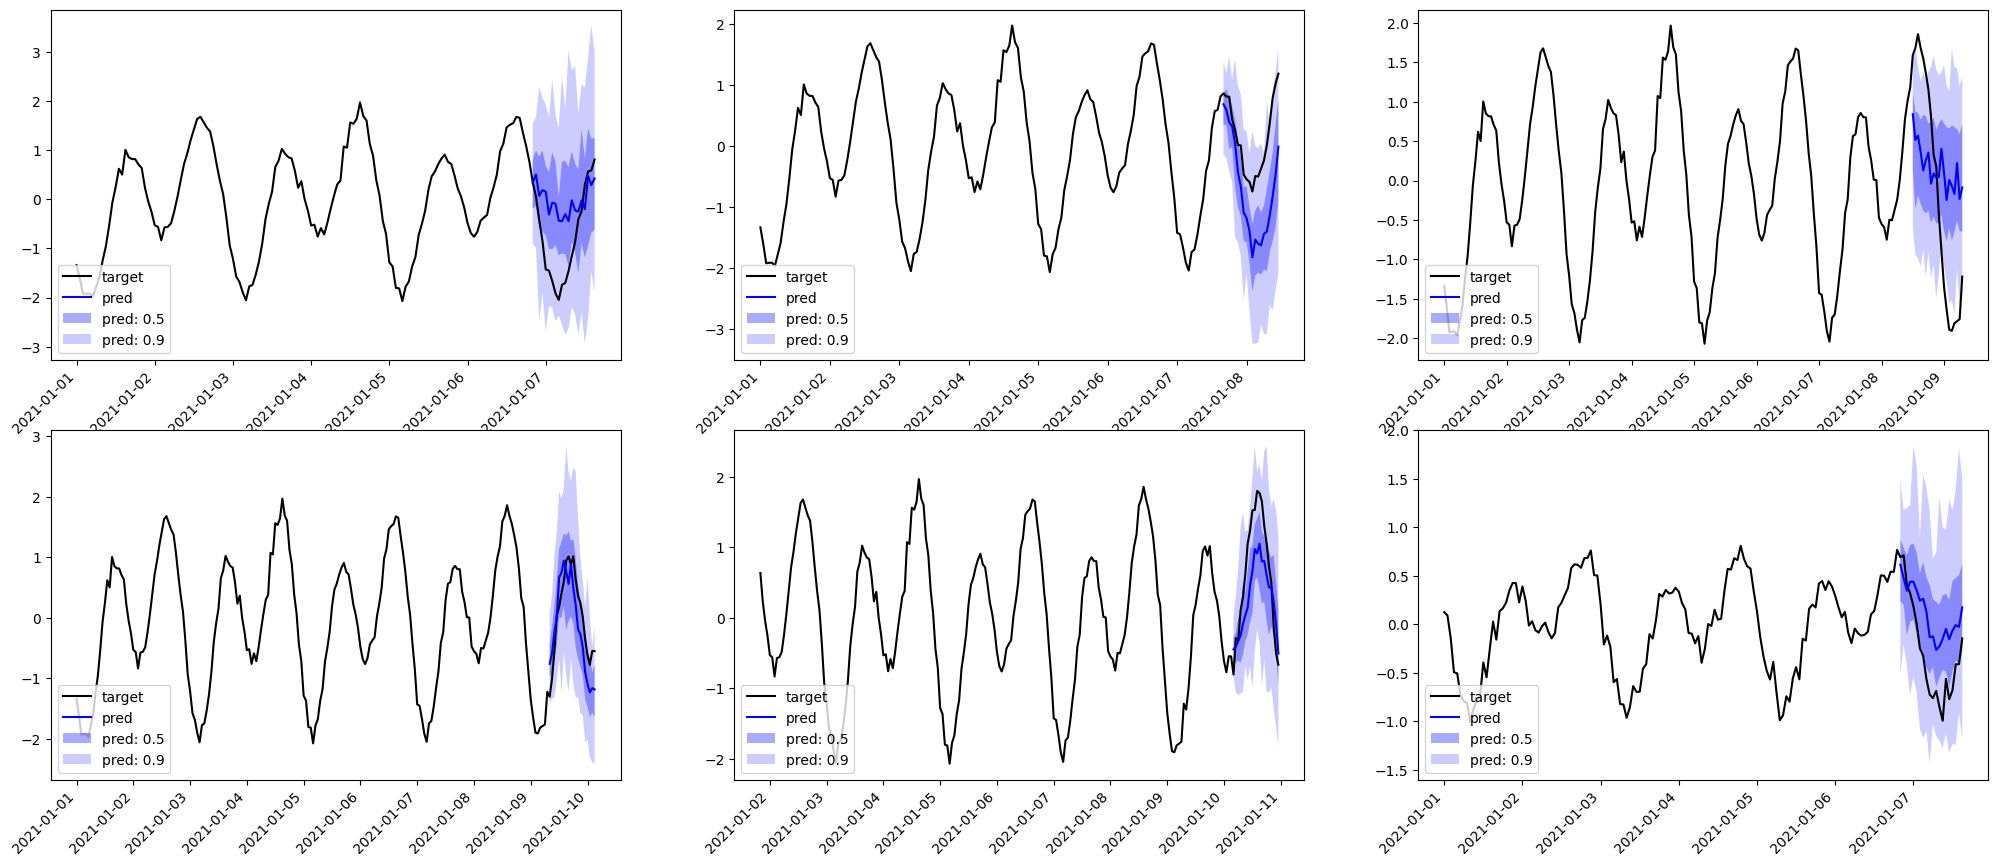

In [23]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)